In [1]:
# Cell 1: Import Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

print("TensorFlow version:", keras.__version__)

TensorFlow version: 3.5.0


In [2]:

# ============================================================================
# Cell 2: Setup Paths and Parameters
# ============================================================================

# Paths
data_dir = 'fish_dataset'

# Hyperparameters
img_height, img_width = 224, 224
batch_size = 32
epochs = 50
learning_rate = 0.001

# Get class names
class_names = sorted(os.listdir(data_dir))
num_classes = len(class_names)

print(f"Found {num_classes} classes:")
for i, name in enumerate(class_names):
    count = len(os.listdir(os.path.join(data_dir, name)))
    print(f"{i+1}. {name}: {count} images")

Found 15 classes:
1. angelfish: 67 images
2. betta fish: 59 images
3. blue tang: 18 images
4. clownfish: 69 images
5. discus: 77 images
6. goldfish: 65 images
7. guppy: 65 images
8. lionfish: 72 images
9. manta ray: 71 images
10. moray eel: 70 images
11. parrotfish: 70 images
12. pufferfish: 63 images
13. seahorse: 6 images
14. swordfish: 63 images
15. zebrafish: 49 images


In [3]:


# ============================================================================
# Cell 3: Data Augmentation and Generators
# ============================================================================

# Training data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 80% train, 20% validation
)

# Validation data (only rescaling)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Training generator
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation generator
validation_generator = val_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

print(f"\nTraining samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")


Found 713 images belonging to 15 classes.
Found 171 images belonging to 15 classes.

Training samples: 713
Validation samples: 171


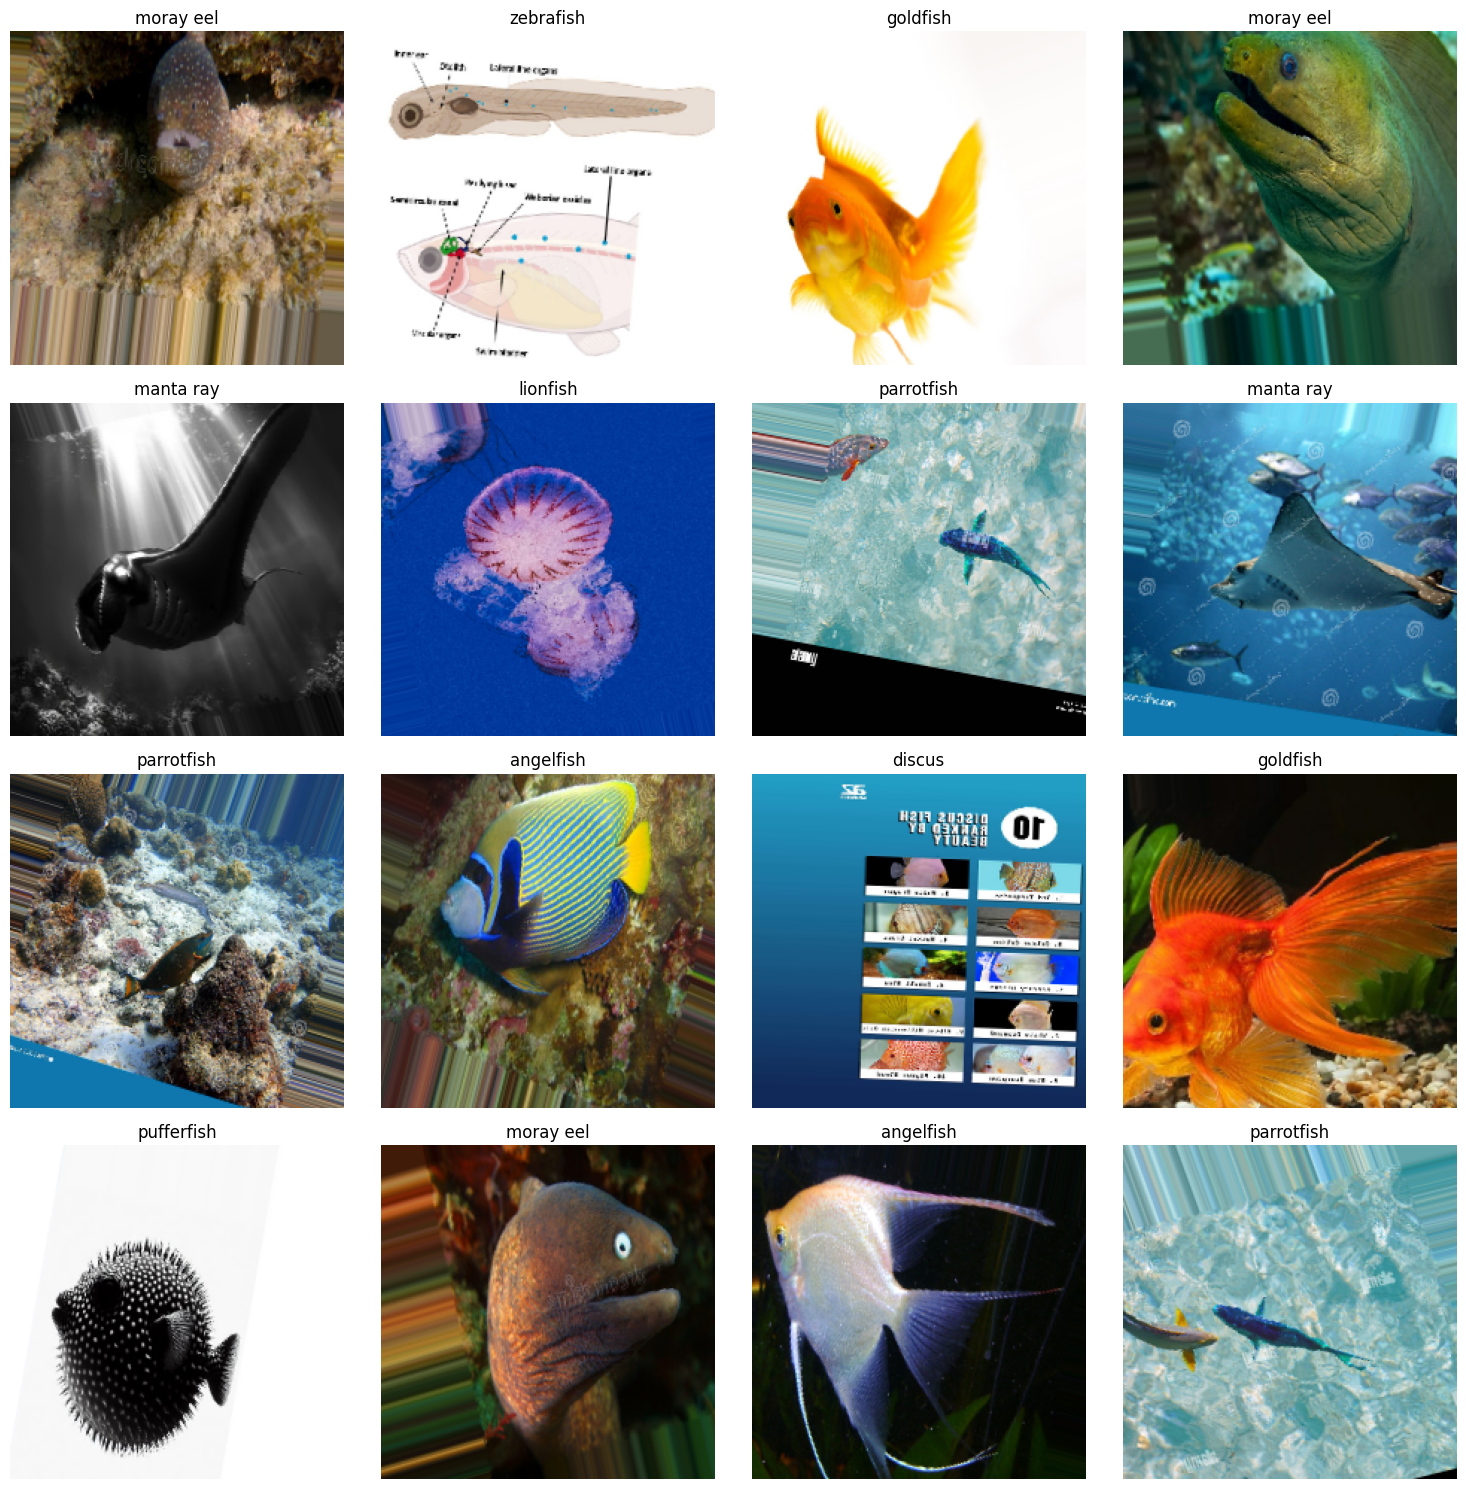

In [4]:

# ============================================================================
# Cell 4: Visualize Sample Images
# ============================================================================

# Get a batch of images
images, labels = next(train_generator)

# Plot 16 sample images
plt.figure(figsize=(15, 15))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(images[i])
    class_idx = np.argmax(labels[i])
    plt.title(class_names[class_idx])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [5]:


# ============================================================================
# Cell 5: Build CNN Model Architecture
# ============================================================================

def create_cnn_model():
    model = keras.Sequential([
        # Block 1
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Block 2
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Block 3
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Block 4
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Dense layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

model = create_cnn_model()
model.summary()


c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 220, 220, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 220, 220, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 108, 108, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 108, 108, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 106, 106, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 106, 106, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 51, 51, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 51, 51, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 49, 49, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 49, 49, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 22, 22, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 22, 22, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 20, 20, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 14,422,063 (55.02 MB)

 Trainable params: 14,418,607 (55.00 MB)

 Non-trainable params: 3,456 (13.50 KB)

In [6]:

# ============================================================================
# Cell 6: Compile Model
# ============================================================================

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'best_fish_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]


In [7]:

# ============================================================================
# Cell 7: Train Model
# ============================================================================

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)

# Save final model
model.save('final_fish_model.keras')
print("\n✅ Model saved as 'final_fish_model.keras'")

Epoch 1/50


c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.0912 - loss: 3.6660 
Epoch 1: val_accuracy improved from -inf to 0.08187, saving model to best_fish_model.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 310s 12s/step - accuracy: 0.0923 - loss: 3.6612 - val_accuracy: 0.0819 - val_loss: 3.1229 - learning_rate: 0.0010
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.1680 - loss: 3.2203
Epoch 2: val_accuracy did not improve from 0.08187
23/23 ━━━━━━━━━━━━━━━━━━━━ 243s 10s/step - accuracy: 0.1680 - loss: 3.2207 - val_accuracy: 0.0702 - val_loss: 3.6482 - learning_rate: 0.0010
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.2106 - loss: 2.9095
Epoch 3: val_accuracy improved from 0.08187 to 0.08772, saving model to best_fish_model.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 241s 10s/step - accuracy: 0.2118 - loss: 2.9059 - val_accuracy: 0.0877 - val_loss: 6.0152 - learning_rate: 0.0010
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.2566 - loss: 2.6967
Epoch 4: val_accur

KeyboardInterrupt: 

In [ ]:


# ============================================================================
# Cell 8: Plot Training History
# ============================================================================

# Plot accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print best scores
best_val_acc = max(history.history['val_accuracy'])
best_epoch = history.history['val_accuracy'].index(best_val_acc) + 1
print(f"\n🏆 Best Validation Accuracy: {best_val_acc:.4f} at epoch {best_epoch}")

# ============================================================================
# Cell 9: Evaluate Model on Validation Set
# ============================================================================

# Load best model
model = keras.models.load_model('best_fish_model.keras')

# Get predictions
validation_generator.reset()
predictions = model.predict(validation_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes

# Classification report
print("\n📊 Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_names))

# ============================================================================
# Cell 10: Confusion Matrix
# ============================================================================

# Compute confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# ============================================================================
# Cell 11: Test Single Image Prediction Function
# ============================================================================

from tensorflow.keras.preprocessing import image

def predict_fish(img_path, model, class_names):
    """
    Predict the fish species from an image
    """
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    
    # Make prediction
    predictions = model.predict(img_array, verbose=0)
    predicted_class_idx = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class_idx]
    predicted_class = class_names[predicted_class_idx]
    
    # Display results
    plt.figure(figsize=(10, 4))
    
    # Show image
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence*100:.2f}%")
    plt.axis('off')
    
    # Show confidence bar chart
    plt.subplot(1, 2, 2)
    top_5_idx = np.argsort(predictions[0])[-5:][::-1]
    top_5_probs = predictions[0][top_5_idx]
    top_5_classes = [class_names[i] for i in top_5_idx]
    
    colors = ['green' if i == 0 else 'skyblue' for i in range(5)]
    plt.barh(top_5_classes, top_5_probs, color=colors)
    plt.xlabel('Confidence')
    plt.title('Top 5 Predictions')
    plt.xlim(0, 1)
    
    plt.tight_layout()
    plt.show()
    
    return predicted_class, confidence

# ============================================================================
# Cell 12: Test on Sample Images
# ============================================================================

# Test on a few random images from validation set
import random

# Get random image paths
test_samples = []
for class_name in class_names[:5]:  # Test first 5 classes
    class_path = os.path.join(data_dir, class_name)
    images = os.listdir(class_path)
    if images:
        random_img = random.choice(images)
        test_samples.append(os.path.join(class_path, random_img))

# Predict each sample
for img_path in test_samples:
    print(f"\n{'='*60}")
    print(f"Testing: {img_path}")
    print('='*60)
    predicted_class, confidence = predict_fish(img_path, model, class_names)
    print(f"✅ Result: {predicted_class} ({confidence*100:.2f}% confidence)")

# ============================================================================
# Cell 13: Interactive Prediction (Upload Your Own Image)
# ============================================================================

# To test your own image, upload it and run:
# Example:
# my_image = "path/to/your/fish/image.jpg"
# predict_fish(my_image, model, class_names)

print("\n" + "="*60)
print("🎉 MODEL TRAINING COMPLETE!")
print("="*60)
print(f"✅ Best model saved: best_fish_model.keras")
print(f"✅ Final model saved: final_fish_model.keras")
print(f"✅ Number of classes: {num_classes}")
print(f"✅ Classes: {', '.join(class_names)}")
print("\nTo predict a new image, use:")
print("predict_fish('path/to/image.jpg', model, class_names)")
print("="*60)